Import libraries.

In [1]:
import numpy as np
import numpy.linalg as npl
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.integrate import solve_ivp

Input data.

In [2]:
timepoints=np.array([7,14,21])
data=np.array([
    [85.2,11.,2.8],
    [40.3,26.3,28.3],
    [35.3,31.7,29.4]
])
data=np.transpose(np.transpose(data)/np.sum(data,axis=1)) # re-scales so that frequencies sum to 1

equilibrium=data[-1,:] #saves final data point as equilibrium

T=24
names=['NK','int','ILC']

In [3]:
print(data)

[[0.86060606 0.11111111 0.02828283]
 [0.42465753 0.27713383 0.29820864]
 [0.36618257 0.32883817 0.30497925]]


Analysis with carrying capacity $K=10^7$

In [4]:
K=1e7 #carrying capacity
p=0.2 #proportion of injected cells that take hold in initial population
n0=p*np.array([5e5,0,0])/K #initial condition

Define ODE function:

$$\frac{\mathrm{d}n^K_j}{\mathrm{d}t}(t)=n^K_j(t)\left(r_j-\sum_{i \in \mathcal{X}}s_{j,i}+\sum_{i \in \mathcal{X}}c_{i,j}n_i(t)\right)+\sum_{i \in \mathcal{X}}s_{i,j}n_i(t),\ j \in \mathcal{X}$$

In [5]:
def ODE(n,growth_rates,switch_rates,competition):
    '''
    n is number of cells (scaled) with dimension d;
    growth_rates as d x 1 vector;
    switch_rates as d x d matrix;
    competition kernel as d x d matrix;
    '''
    dim=len(n)
    dndt=np.zeros(dim)
    for i in range(dim):
        dndt[i]=n[i]*(growth_rates[i]-np.sum(switch_rates[i,:])-competition[i,:].dot(n))+switch_rates[:,i].dot(n)
    return dndt

Define function which finds competition parameters $c_\text{self}$, $c_\text{int,ILC}$, and $c_\text{ILC,int}$ by setting the ODE to 0 at time $t=T$:

In [6]:
def get_competition(growth_rates,switch_rates,equilibrium):
    '''
    Function that returns competition kernel assuming equal self-competition, no competition between NK and int/ILC cells, and
    enforcing equilibrium at given point
    '''
    A=np.array([
        [equilibrium[0]**2,0,0],
        [equilibrium[1]**2,equilibrium[1]*equilibrium[2],0],
        [equilibrium[2]**2,0,equilibrium[1]*equilibrium[2]]
               ])
    b=np.array([
        equilibrium[0]*(growth_rates[0]-switch_rates[0,1]),
        equilibrium[0]*switch_rates[0,1]+equilibrium[1]*(growth_rates[1]-switch_rates[1,2]),
        equilibrium[1]*switch_rates[1,2]+equilibrium[2]*growth_rates[2]
        ])
    
    c=npl.solve(A,b)
    competition=c[0]*np.eye(3)
    competition[1,2]=c[1]
    competition[2,1]=c[2]
    return competition

Simulate plots with equal growth rates ranging from $0.01$ to $3$ and switch-rates ranging from $10^{-6}$ to $10^{-1}$. For each switch rate, the code runs through 500 values for the common growth-rate $r$. The competition kernel is set so that the datapoint at $t=21$ is an equilibrium for the system with these switch- and growth-rates. Then the growth-rate with the least squared error from the actual data is chosen as the optimal growth-rate for this switch-rate, and the fit is plotted.

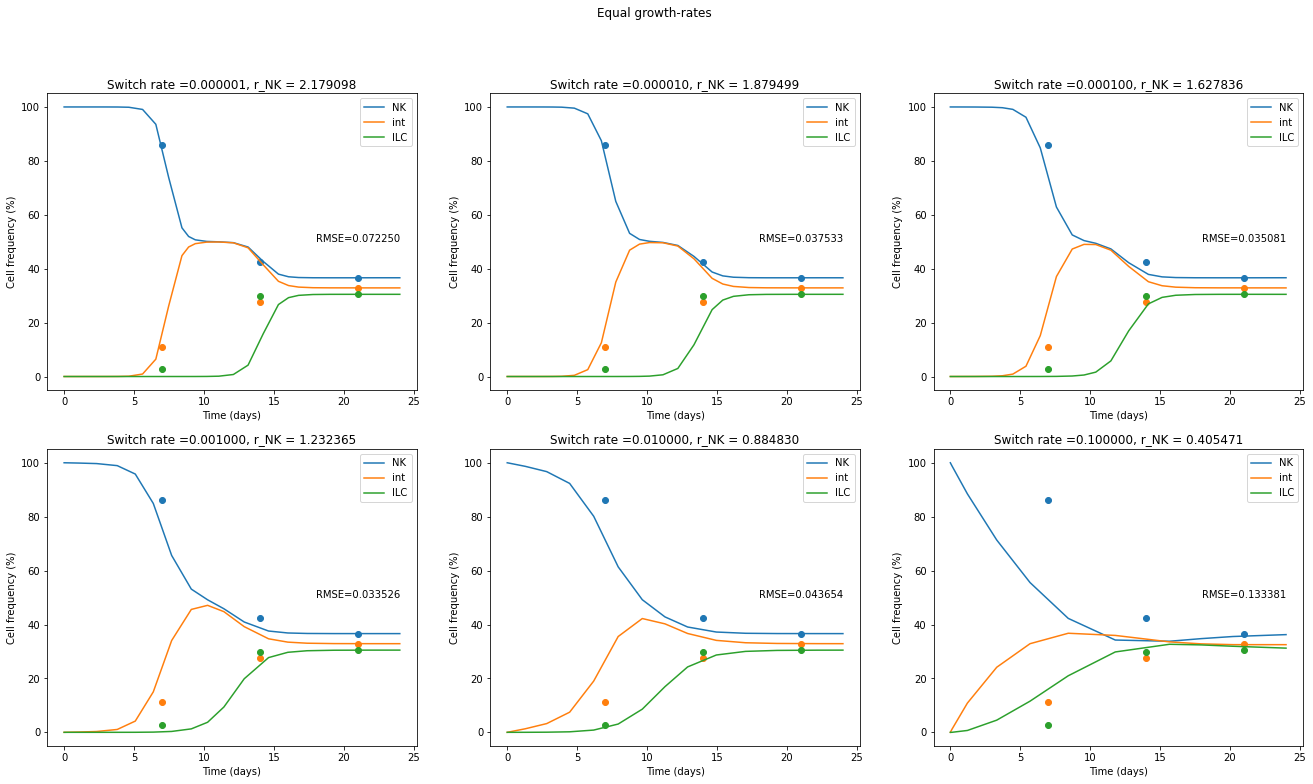

In [7]:
squared_errors=[]
saved_values=np.zeros(12)
rates=np.linspace(0.01,3,500)
s_vals=np.array([1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])
fig, axs=plt.subplots(2,3)
fig.set_figheight(12)
fig.set_figwidth(22.5)
for l in range(len(s_vals)):
    squared_errors=[]
    s=s_vals[l]
    switch_rates=s*np.array([[0,1,0],
                            [0,0,1],
                            [0,0,0]])
    for j in range(len(rates)):
        growth_rates=rates[j]*np.ones(3)
        competition=get_competition(growth_rates,switch_rates,equilibrium)
        rhs=lambda t,n: ODE(n,growth_rates,switch_rates,competition)
        sim=solve_ivp(rhs,(0,T),n0)
        squared_errors=np.append(squared_errors,np.sum((data-[(sim['y']/np.sum(sim['y'],axis=0))[:,np.argmin(abs(sim['t']-t))]for t in timepoints])**2))
    r_nk=rates[np.argmin(squared_errors)]
    RMSE=np.sqrt(min(squared_errors)/(len(timepoints)*len(data[0,:])))
    
    growth_rates=r_nk*np.ones(3)
    competition=get_competition(growth_rates,switch_rates,equilibrium)
    saved_values=np.vstack((saved_values,np.concatenate(([s,r_nk,RMSE],competition.reshape(9)))))
    
    rhs=lambda t,n: ODE(n,growth_rates,switch_rates,competition)
    sim=solve_ivp(rhs,(0,T),n0)
    ax=axs[round(l/5),np.mod(l,3)]

    for i in range(3):
        ax.plot(sim['t'],100*(sim['y']/np.sum(sim['y'],axis=0))[i],label=names[i])
        ax.scatter(timepoints,100*data[:,i],marker='o')
    ax.legend()
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Cell frequency (%)')
    ax.set_title('Switch rate =%f, r_NK = %f'%(s,r_nk))
    ax.text(18,50,'RMSE=%f'%(RMSE))

plt.suptitle('Equal growth-rates')
plt.show()
    
col_names=['Switch rate','r_NK','RMSE','c_NK,NK','c_NK,int','c_NK,ILC','c_int,NK','c_int,int','c_int,ILC','c_ILC,NK','c_ILC,int','c_ILC,ILC']
output_requal=pd.DataFrame(saved_values[1:],columns=col_names)

By visual inspection, best switch-rates seems to be close to $0.01$. We repeat this process with more switch-rates closer to optimal parameter:

In [8]:
squared_errors=[]
saved_values=np.zeros(12)
rates=np.linspace(0.2,2,100)
s_vals=np.linspace(0.003,0.015,100)

for l in range(len(s_vals)):
    squared_errors=[]
    s=s_vals[l]
    switch_rates=s*np.array([[0,1,0],
                            [0,0,1],
                            [0,0,0]])
    for j in range(len(rates)):
        growth_rates=rates[j]*np.ones(3)
        competition=get_competition(growth_rates,switch_rates,equilibrium)
        rhs=lambda t,n: ODE(n,growth_rates,switch_rates,competition)
        sim=solve_ivp(rhs,(0,T),n0)
        squared_errors=np.append(squared_errors,np.sum((data-[(sim['y']/np.sum(sim['y'],axis=0))[:,np.argmin(abs(sim['t']-t))]for t in timepoints])**2))
    r_nk=rates[np.argmin(squared_errors)]
    RMSE=np.sqrt(min(squared_errors)/(len(timepoints)*len(data[0,:])))
    
    growth_rates=r_nk*np.ones(3)
    competition=get_competition(growth_rates,switch_rates,equilibrium)
    saved_values=np.vstack((saved_values,np.concatenate(([s,r_nk,RMSE],competition.reshape(9)))))
    
col_names=['Switch rate','r_NK','RMSE','c_NK,NK','c_NK,int','c_NK,ILC','c_int,NK','c_int,int','c_int,ILC','c_ILC,NK','c_ILC,int','c_ILC,ILC']
output=pd.DataFrame(saved_values[1:],columns=col_names)

In [9]:
best_params=output.iloc[np.argmin(output['RMSE'])]
s=best_params['Switch rate']
switch_rates=s*np.array([[0,1,0],
                        [0,0,1],
                         [0,0,0]])
r=best_params['r_NK']
competition=np.array(best_params[3:]).reshape((3,3))
growth_rates=r*np.ones(3)
RMSE=best_params['RMSE']

In [10]:
best_params

Switch rate    0.004818
r_NK           0.927273
RMSE           0.033870
c_NK,NK        2.519111
c_NK,int       0.000000
c_NK,ILC       0.000000
c_int,NK       0.000000
c_int,int      2.519111
c_int,ILC      0.326055
c_ILC,NK       0.000000
c_ILC,int      0.499307
c_ILC,ILC      2.519111
Name: 15, dtype: float64

Plot to check that we are near a local minimum

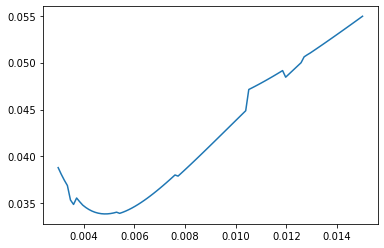

In [11]:
plt.plot(output['Switch rate'],output['RMSE'])

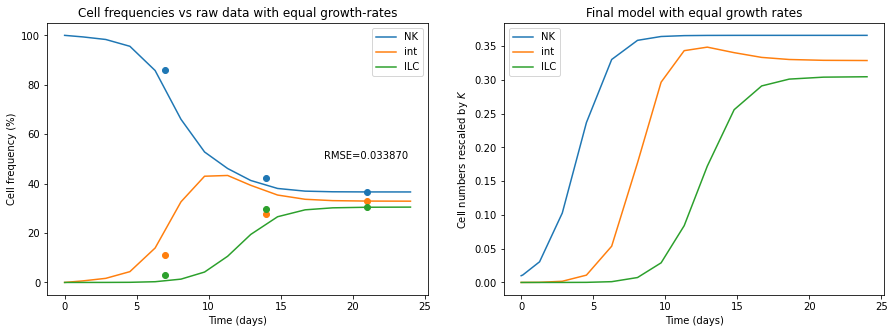

In [12]:
rhs=lambda t,n: ODE(n,growth_rates,switch_rates,competition)
sim=solve_ivp(rhs,(0,T),n0)

fig, axs=plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)

for i in range(3):
    axs[0].plot(sim['t'],100*(sim['y']/np.sum(sim['y'],axis=0))[i],label=names[i])
    axs[0].scatter(timepoints,100*data[:,i],marker='o')
    axs[1].plot(sim['t'],sim['y'][i],label=names[i])
axs[0].legend()
axs[0].set_xlabel('Time (days)')
axs[0].set_ylabel('Cell frequency (%)')
axs[0].set_title('Cell frequencies vs raw data with equal growth-rates')
axs[0].text(18,50,'RMSE=%f'%(RMSE))

axs[1].legend()
axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Cell numbers rescaled by $K$')
axs[1].set_title('Final model with equal growth rates')

plt.show()

Plot (re-scaled) absolute cell numbers:

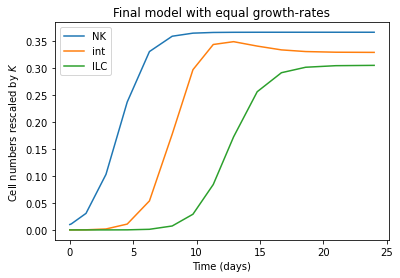

In [13]:
rhs=lambda t,n: ODE(n,growth_rates,switch_rates,competition)
sim=solve_ivp(rhs,(0,T),n0)

for i in range(3):
    plt.plot(sim['t'],sim['y'][i],label=names[i])
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Cell numbers rescaled by $K$')
plt.title('Final model with equal growth-rates')
#plt.text(18,50,'RMSE=%f'%(RMSE))
plt.show()

Reduce $r_\text{int}$ and repeat analysis

Function to reduce $r_\text{int}$ but keep competition kernel non-negative, based on the inequality:

$$r_\text{int}\geq r_\text{NK}\frac{E_\text{int}}{E_\text{NK}}+s_\text{int,ILC}-s_\text{NK,int}\left(\frac{E_\text{NK}}{E_\text{int}}+\frac{E_\text{int}}{E_\text{NK}}\right)$$

In [14]:
def red_r_int(r_nk,switch_rates,equilibrium,kappa=0):
    #kappa between 0 and 1
    return r_nk*equilibrium[1]/equilibrium[0]-kappa*(switch_rates[0]*(equilibrium[1]/equilibrium[0]+equilibrium[0]/equilibrium[1])-switch_rates[1])

In [15]:
kappa=0

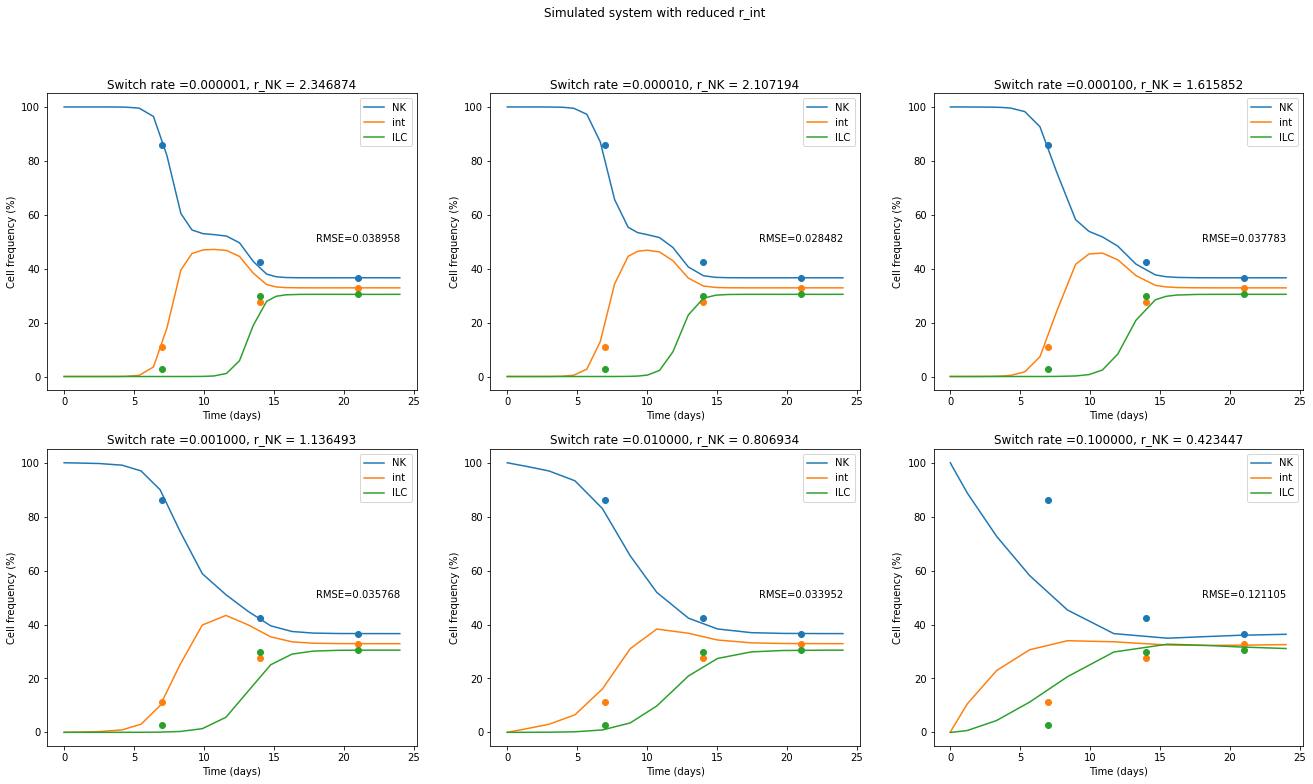

In [16]:
squared_errors=[]
saved_values=np.zeros(12)
rates=np.linspace(0.01,3,500)
s_vals=np.array([1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])
fig, axs=plt.subplots(2,3)
fig.set_figheight(12)
fig.set_figwidth(22.5)
for l in range(len(s_vals)):
    squared_errors=[]
    s=s_vals[l]
    switch_rates=s*np.array([[0,1,0],
                            [0,0,1],
                            [0,0,0]])
    for j in range(len(rates)):
        growth_rates=np.array([rates[j],red_r_int(rates[j],s*np.ones(2),equilibrium,kappa),rates[j]])
        competition=get_competition(growth_rates,switch_rates,equilibrium)
        rhs=lambda t,n: ODE(n,growth_rates,switch_rates,competition)
        sim=solve_ivp(rhs,(0,T),n0)
        squared_errors=np.append(squared_errors,np.sum((data-[(sim['y']/np.sum(sim['y'],axis=0))[:,np.argmin(abs(sim['t']-t))]for t in timepoints])**2))
    r_nk=rates[np.argmin(squared_errors)]
    RMSE=np.sqrt(min(squared_errors)/(len(timepoints)*len(data[0,:])))
    
    growth_rates=np.array([r_nk,red_r_int(r_nk,s*np.ones(2),equilibrium,kappa),r_nk])
    competition=get_competition(growth_rates,switch_rates,equilibrium)
    saved_values=np.vstack((saved_values,np.concatenate(([s,r_nk,RMSE],competition.reshape(9)))))
    
    rhs=lambda t,n: ODE(n,growth_rates,switch_rates,competition)
    sim=solve_ivp(rhs,(0,T),n0)
    ax=axs[round(l/5),np.mod(l,3)]

    for i in range(3):
        ax.plot(sim['t'],100*(sim['y']/np.sum(sim['y'],axis=0))[i],label=names[i])
        ax.scatter(timepoints,100*data[:,i],marker='o')
    ax.legend()
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Cell frequency (%)')
    ax.set_title('Switch rate =%f, r_NK = %f'%(s,r_nk))
    ax.text(18,50,'RMSE=%f'%(RMSE))

plt.suptitle('Simulated system with reduced r_int')
plt.show()
    
col_names=['Switch rate','r_NK','Squared_error','c_NK,NK','c_NK,int','c_NK,ILC','c_int,NK','c_int,int','c_int,ILC','c_ILC,NK','c_ILC,int','c_ILC,ILC']
output_rint_red=pd.DataFrame(saved_values[1:],columns=col_names)
#output_rint_red

Again, by visual inspection, $0.01$ seems the best switch-rate. Repeat closer to optimal parameter with more values:

In [17]:
squared_errors=[]
saved_values=np.zeros(12)
rates=np.linspace(0.2,2,100)
s_vals=np.linspace(0.003,0.015,100)

for l in range(len(s_vals)):
    squared_errors=[]
    s=s_vals[l]
    switch_rates=s*np.array([[0,1,0],
                            [0,0,1],
                            [0,0,0]])
    for j in range(len(rates)):
        growth_rates=np.array([rates[j],red_r_int(rates[j],s*np.ones(2),equilibrium,kappa),rates[j]])
        competition=get_competition(growth_rates,switch_rates,equilibrium)
        rhs=lambda t,n: ODE(n,growth_rates,switch_rates,competition)
        sim=solve_ivp(rhs,(0,T),n0)
        squared_errors=np.append(squared_errors,np.sum((data-[(sim['y']/np.sum(sim['y'],axis=0))[:,np.argmin(abs(sim['t']-t))]for t in timepoints])**2))
    r_nk=rates[np.argmin(squared_errors)]
    RMSE=np.sqrt(min(squared_errors)/(len(timepoints)*len(data[0,:])))
    
    growth_rates=np.array([r_nk,red_r_int(r_nk,s*np.ones(2),equilibrium,kappa),r_nk])
    competition=get_competition(growth_rates,switch_rates,equilibrium)
    saved_values=np.vstack((saved_values,np.concatenate(([s,r_nk,RMSE],competition.reshape(9)))))
    
col_names=['Switch rate','r_NK','RMSE','c_NK,NK','c_NK,int','c_NK,ILC','c_int,NK','c_int,int','c_int,ILC','c_ILC,NK','c_ILC,int','c_ILC,ILC']
output_rint_red=pd.DataFrame(saved_values[1:],columns=col_names)

In [20]:
best_params=output_rint_red.iloc[np.argmin(output_rint_red['RMSE'])]
s=best_params['Switch rate']
switch_rates=s*np.array([[0,1,0],
                        [0,0,1],
                         [0,0,0]])
r=best_params['r_NK']
competition=np.array(best_params[3:]).reshape((3,3))
growth_rates=np.array([r,red_r_int(r,s*np.ones(2),equilibrium,0),r])
RMSE=best_params['RMSE']

pd.DataFrame(np.concatenate((growth_rates,competition.reshape(9),np.array([s,s])))).to_csv("init_params.csv",index=False)

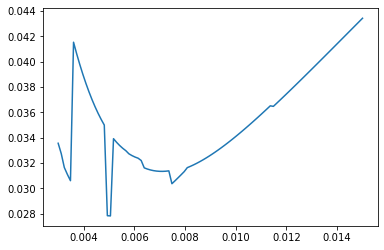

In [21]:
plt.plot(output_rint_red['Switch rate'],output_rint_red['RMSE'])

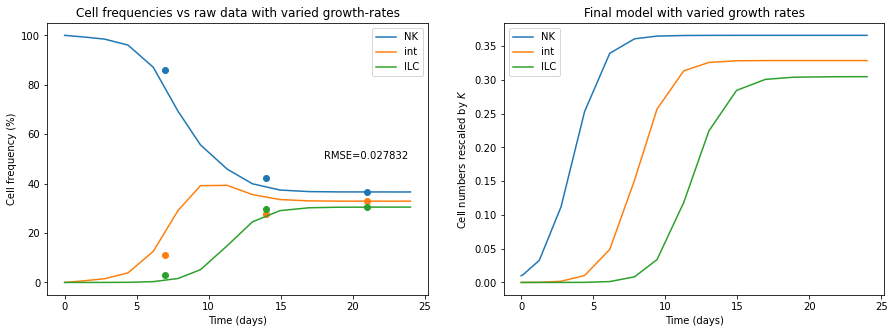

In [23]:
rhs=lambda t,n: ODE(n,growth_rates,switch_rates,competition)
sim=solve_ivp(rhs,(0,T),n0)

fig, axs=plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)

for i in range(3):
    axs[0].plot(sim['t'],100*(sim['y']/np.sum(sim['y'],axis=0))[i],label=names[i])
    axs[0].scatter(timepoints,100*data[:,i],marker='o')
    axs[1].plot(sim['t'],sim['y'][i],label=names[i])
axs[0].legend()
axs[0].set_xlabel('Time (days)')
axs[0].set_ylabel('Cell frequency (%)')
axs[0].set_title('Cell frequencies vs raw data with varied growth-rates')
axs[0].text(18,50,'RMSE=%f'%(RMSE))

axs[1].legend()
axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Cell numbers rescaled by $K$')
axs[1].set_title('Final model with varied growth rates')

plt.show()

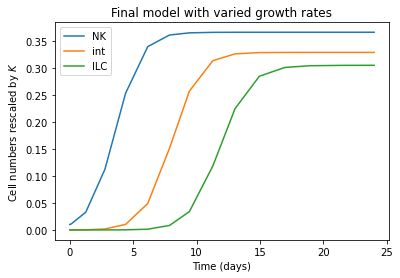

In [24]:
for i in range(3):
    plt.plot(sim['t'],sim['y'][i],label=names[i])
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Cell numbers rescaled by $K$')
plt.title('Final model with varied growth rates')
plt.show()

In [25]:
red_r_int(r,s*np.ones(2),equilibrium,kappa)

0.8980169971671389

Now that we have a model, we can generate some mock absolute cell-numbers data in order to test out other fitting methods. We generate the data as points predicted by the model with reduced $r_{int}$ and add some centred normal random noise with variance given by $\sigma^2=(RMSE\times \tilde{N})^2$ where $\tilde{N}$ is the average population size over the timespan considered

In [26]:
times=np.linspace(0,22,23)
sim=solve_ivp(rhs,(0,22),n0,t_eval=times)
np.random.seed(222)
avg_pop_size=np.mean(np.sum(sim['y'],axis=0))
datapoints=sim['y']+np.random.normal(0,scale=avg_pop_size*RMSE,size=sim['y'].shape)
datapoints=np.transpose(np.vstack((n0,np.transpose(datapoints[:,1:])))) # removes noise from initial condition
datapoints=np.maximum(datapoints,np.zeros(datapoints.shape)) #sets negative data to zero
datapoints[:,np.isin(times,timepoints)]=np.transpose(data)*np.sum(datapoints[:,np.isin(times,timepoints)],axis=0) # forces mock data to agree with actual frequencies at times for which frequency data is available

In [27]:
mock_df=pd.DataFrame(np.transpose(np.vstack((times,datapoints))),columns=['t','NK','int','ILC'])
mock_df.to_csv("mock_df.csv")

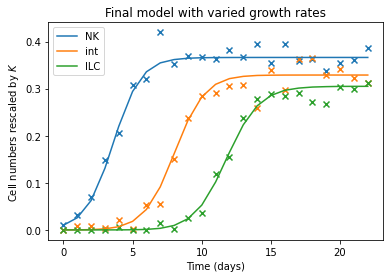

In [28]:
for i in range(3):
    plt.plot(sim['t'],sim['y'][i],label=names[i])
    plt.scatter(times,datapoints[i],marker='x')
    #plt.scatter(timepoints,datapoints[:,timepoints][i],marker='o')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Cell numbers rescaled by $K$')
plt.title('Final model with varied growth rates')
plt.show()